In [38]:
import cltk
import medlatin
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

## Generating style vectors from the reduced Medlatin1 dataset

In [39]:
lat_cltk = cltk.NLP(language='lat', suppress_banner=True)
lat_cltk.pipeline.processes.remove(cltk.lexicon.processes.LatinLexiconProcess)
# remove process since it slows the code (it adds definitions to each word)
# lat_cltk.pipeline.processes.remove(cltk.embeddings.processes.LatinEmbeddingsProcess)
# remove process since it slows the code (it generates word2vec embeddings)

In [40]:
medlatin1_path = '../MedLatin/Corpora/MedLatinEpi'

medlatin1_texts, medlatin1_authors, medlatin_titles = medlatin.load_medlatin(medlatin1_path)

In [41]:
author_changes_idx = [i for i in range(len(medlatin1_authors)) if medlatin1_authors[i-1] != medlatin1_authors[i]]
author_changes_names = [medlatin1_authors[i] for i in author_changes_idx]
# Clara, and Misc have too few texts and they mess with the clustering
# let's try running the experiments without their texts to see the results
from_dante_idx = author_changes_idx[author_changes_names.index('Dante')]
to_misc_idx = author_changes_idx[author_changes_names.index('Misc')]
from_vigna_idx = author_changes_idx[author_changes_names.index('PierDellaVigna')]

In [42]:
# this results in 260 texts
medlatin1_texts = medlatin1_texts[from_dante_idx:to_misc_idx] + medlatin1_texts[from_vigna_idx:]

In [43]:
author_changes_idx = author_changes_idx[author_changes_names.index('Dante'):author_changes_names.index('Misc')+1]
author_changes_idx = [i - from_dante_idx for i in author_changes_idx]
author_changes_names = ['Dante', 'GiovanniBoccaccio', 'GuidoFaba', 'PierDellaVigna']

In [ ]:
# these lists of lists contain POS-tags, embeddings and tokens for each text in the dataset
medlatin1_pos, medlatin1_emb, medlatin1_tokens = medlatin.generate_text_vectors(medlatin1_texts, lat_cltk)

In [45]:
medlatin1_tokens_counter= medlatin.token_counter(medlatin1_tokens)
# we don't want to count punctuation among the most common tokens
stop_list = [',', '.', '', ';', ':']
medlatin1_most_common_tokens = medlatin.get_common_tokens(medlatin1_tokens_counter, n=20, stop_list=stop_list)

In [46]:
# this combines the lists of POS-tags and tokens so that the most common tokens 
# are left as is while other tokens are replaced by their POS-tags
medlatin1_combined_pos_tokens = medlatin.combine_pos_most_common_tokens(medlatin1_tokens,
                                                                        medlatin1_pos,
                                                                        medlatin1_most_common_tokens)

In [47]:
word_tfidf = medlatin.word_tfidf(medlatin1_combined_pos_tokens)
char_tfidf = medlatin.char_tfidf(medlatin1_tokens)
# this combines the word based and character based TF-IDF matrices so that we have a 
# new matrix of shape (len(texts), word_tfidf.shape[1]+char_tfidf.shape[1])
medlatin_tfidf = np.append(word_tfidf.toarray(), char_tfidf.toarray(), axis=1)
# we have to take the mean of each text's word embeddings to get one embedding per text
medlatin1_emb_mean = [np.array(embeddings).mean(axis=0) for embeddings in medlatin1_emb]
medlatin1_emb_mean = np.array(medlatin1_emb_mean)

In [48]:
# saving the default style vectors to a csv file (n=2, r=100)
np.savetxt('csvfiles/tfidf_n2_r100.csv', medlatin_tfidf, delimiter=',')
# saving the embeddings to a csv file (they do not depend on rank or ngram size)
np.savetxt('csvfiles/embeddings.csv', medlatin1_emb_mean, delimiter=',')

# saving the author names
with open('csvfiles/author_changes_names.txt', 'w', encoding='utf-8') as f:
    for name in author_changes_names:
        f.write(f'{name}\n')

# saving the indices where the authors change
with open('csvfiles/author_changes_idx.txt', 'w', encoding='utf-8') as f:
    for i in author_changes_idx:
        f.write(f'{i}\n')

### Trying different rank (max_feats) and ngram hyperparameters

In [49]:
ngrams_list = [1, 2, 3, 4]
tfidf_dict = {}
for ngram in ngrams_list:
    word_tfidf = medlatin.word_tfidf(medlatin1_combined_pos_tokens, ngrams=ngram)
    char_tfidf = medlatin.char_tfidf(medlatin1_tokens, ngrams=ngram)
    word_char_tfidf = np.append(word_tfidf.toarray(), char_tfidf.toarray(), axis=1)
    tfidf_dict[ngram] = word_char_tfidf

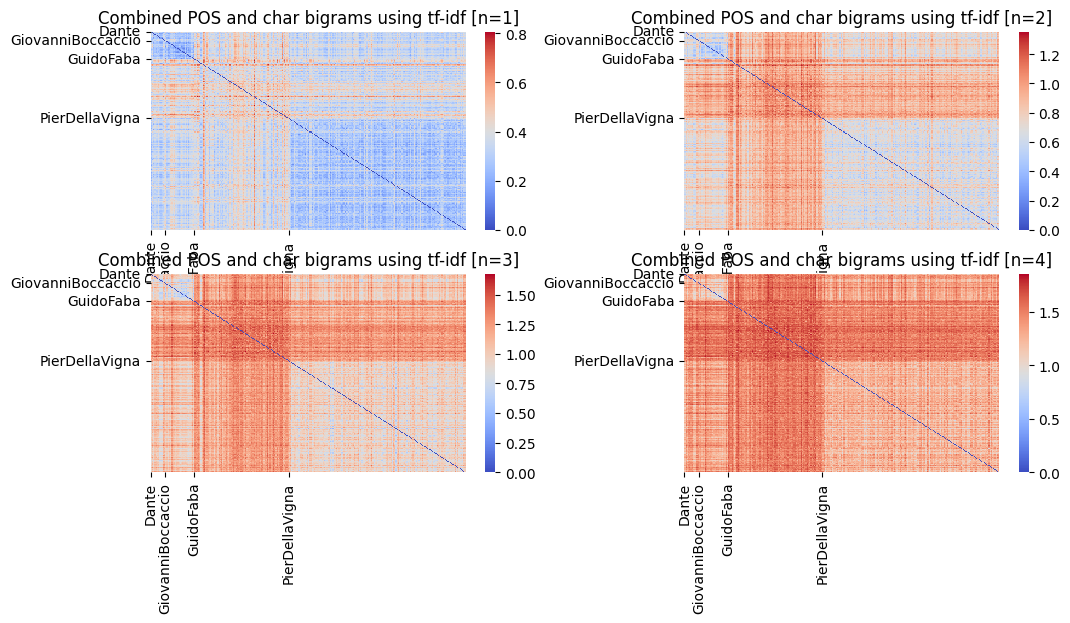

In [50]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

for idx, ax in enumerate(axes.reshape(-1)): 
    sns.heatmap(pairwise_distances(tfidf_dict[ngrams_list[idx]]), cmap='coolwarm', ax=ax)
    ax.set_title(f'Combined POS and char bigrams using tf-idf [n={ngrams_list[idx]}]')
    ax.set_yticks(author_changes_idx)
    ax.set_yticklabels(author_changes_names)
    ax.set_xticks(author_changes_idx)
    ax.set_xticklabels(author_changes_names)

In [51]:
# there are four different authors in the reduced set of texts
n_authors = len(author_changes_names)
kmean_dict = {}
for tfidf_rank in tfidf_dict:
    kmean_100_tfidf = []
    kmean_100_emb = []
    for i in range(100):
        kmeans_tfidf = KMeans(n_clusters=n_authors, n_init='auto').fit(word_char_tfidf)
        kmeans_emb = KMeans(n_clusters=n_authors, n_init='auto').fit(medlatin1_emb_mean)
        kmean_100_tfidf.append(kmeans_tfidf.labels_)
        kmean_100_emb.append(kmeans_emb.labels_)

    kmean_100_tfidf = np.array(kmean_100_tfidf)
    kmean_100_emb = np.array(kmean_100_emb)
    kmean_dict[tfidf_rank] = kmean_100_tfidf

In [52]:
concordances_dict = {}
for kmean_rank in kmean_dict:
    concordances_heatmap_tfidf = []

    kmean = kmean_dict[kmean_rank]
    for epi_idx in range(kmean.shape[1]):
        concordances_tfidf = []


        for epi_jdx in range(kmean.shape[1]):
            # to calculate the concordance rate we take all cluster labels for the text at epi_idx and compare to the labels
            # for the text at epi_jdx - if the first is [1, 1, 2] and the second is [1, 0, 2], then the concordance is [1, 0, 1]
            # the ones represent that they have the same cluster at that position, while 0 means different cluster labels
            # finally the concordance rate is 0.67, which we calculate by taking the mean of the concordance
            concordance_tfidf = sum(kmean[:, epi_idx] == kmean[:, epi_jdx])/kmean.shape[0]
            concordances_tfidf.append(concordance_tfidf)

        concordances_heatmap_tfidf.append(concordances_tfidf)

    concordances_dict[kmean_rank] = concordances_heatmap_tfidf

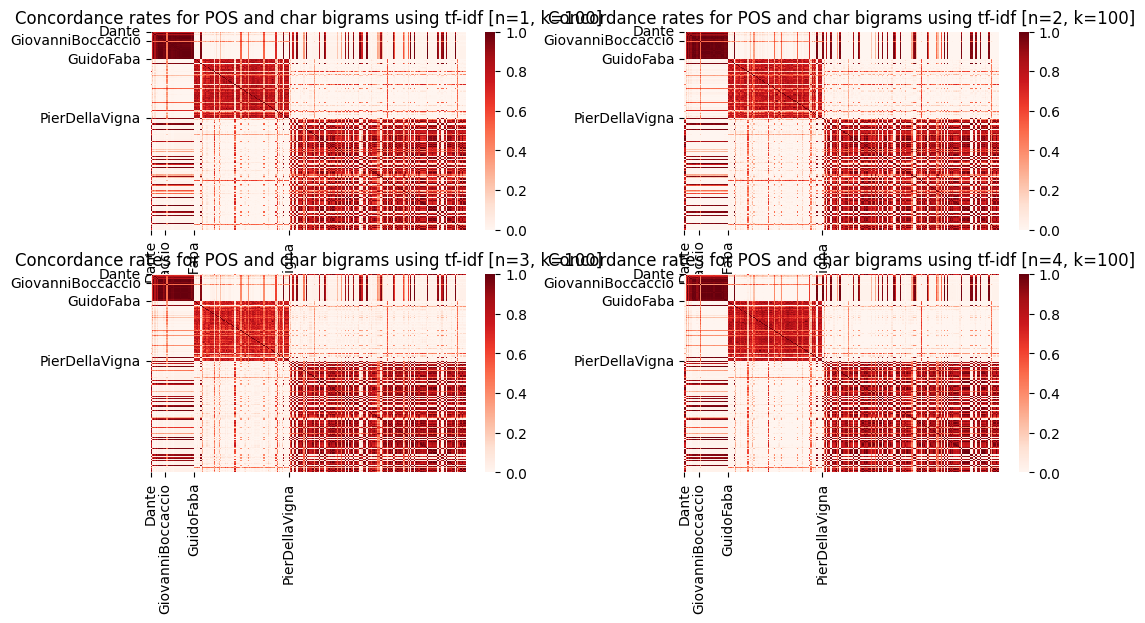

In [53]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 5)
plt.tight_layout(w_pad=7)

for idx, ax in enumerate(axes.reshape(-1)): 
    sns.heatmap(concordances_dict[ngrams_list[idx]], cmap='Reds', ax=ax)
    ax.set_title(f'Concordance rates for POS and char bigrams using tf-idf [n={ngrams_list[idx]}, k=100]')
    ax.set_yticks(author_changes_idx)
    ax.set_yticklabels(author_changes_names)
    ax.set_xticks(author_changes_idx)
    ax.set_xticklabels(author_changes_names)